# Assignment 2 : COMP47750 Machine Learning with Python 
### Submitted by - Rasik Kane - SN 19200172

In [432]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [433]:
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from imblearn.pipeline import Pipeline as imb_pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [434]:
# define seed for random_state
seed = 0
# cross valisation folds
cv_folds = 10

## Supporting functions

### Generate dataframe holding classifier result statistics

In [435]:
def make_results(results, stat_col =['model','acc','prec_minr','recall_minr',
                                     'f1_minr','test%_minr','predict%_minr']):
    
    df_stat = pd.DataFrame(columns= stat_col
                          )
    for result in results:
        df_stat = df_stat.append(result, ignore_index=True)
        
    return df_stat

### Print results

In [436]:
def print_results(df_stat):
    print(tabulate(df_stat, headers=df_stat.columns,
                   tablefmt="orgtbl", 
                   floatfmt=".2f",
                   showindex=False))
    

### Plot from a dataframe

In [437]:
def plot_df_bar(df, kind='bar',figsize=(6,4),grid=True, use_index=True,colormap='winter', rot=20,
                ylabel='Accuracy', xlabel='All feautures',title= 'Model Accuracy Plot', show=True):
                df.dropna().plot(kind=kind,figsize=figsize,grid=grid, use_index=use_index, rot=rot, colormap=colormap)
                plt.ylabel(ylabel)
                plt.xlabel(xlabel)
                plt.title(title)
                if show:
                    plt.show()

### Predict classification with hold-out

In [438]:
def predict_hold_out(model, X_train, X_test, y_train, y_test, min_label, display = False):

    y_pred = model.fit(X_train, y_train).predict(X_test)
    pred_neg = Counter(y_pred)[min_label]
    test_neg = Counter(y_test)[min_label]
    accuracy = accuracy_score(y_pred, y_test)
    precision, recall, fscore, support = score(y_test, y_pred)
    test_minority_proportion = (test_neg/len(y_test))   
    predict_minority_proportion = (pred_neg/len(y_pred))
    
    if display:
        print(classification_report(y_test, y_pred))


    # columns for result about feature classification accuracy and bias   
    columns=['model','acc','prec_minr','recall_minr','f1_minr','test%_minr','predict%_minr']
    # return result
    result = pd.Series([type(model).__name__,accuracy, precision[1], recall[1], fscore[1],
                        test_minority_proportion, predict_minority_proportion
                       ],index = columns)

    return result


### Predict classification with cross validation

In [439]:
def predict_cross_val(model, adasyn, X, y, min_label, cvVal = 10, display = False, upsample=True):
    
    if upsample:
        pipe = imb_pipeline([('adasyn', adasyn), ('model', model)])
    else:
        pipe = model
        
    y_pred = cross_val_predict(pipe,X, y, cv=cvVal)
    pred_neg = Counter(y_pred)[min_label]
    test_neg = Counter(y)[min_label] 
    accuracy = accuracy_score(y_pred, y)
    precision, recall, fscore, support = score(y, y_pred)
    test_minority_proportion = (test_neg/len(y))
    predict_minority_proportion = (pred_neg/len(y_pred))
    
    if display:
        print(classification_report(y, y_pred))

    # columns for result about feature classification accuracy and bias   
    columns=['model','acc','prec_minr','recall_minr','f1_minr','test%_minr','predict%_minr']
    # return result
    result = pd.Series([type(model).__name__,accuracy, precision[1], recall[1], fscore[1],
                        test_minority_proportion, predict_minority_proportion
                       ],index = columns)

    return result


---

# Q1 Bias rectification & evaluation

<span style="color:blue">  

* assess the impact of bias rectification techniques on machine learning using pipeline and cross validation
* evaluate differences in evaluations using hold out and cross validation
</span>
<br>
<br>

**Data Set Information**<br>
The dataset contains cases from a study that was conducted between 1958 and 1970 at the University of Chicago's Billings Hospital on the survival of patients who had undergone surgery for breast cancer.

**Attribute Information**
* Age of patient at time of operation (numerical) - Importance in virtues: **Immunity, healing rate, psychology** 
* Patient's year of operation (year - 1900, numerical)  - Importance  in virtues: **medical technology, contemporary diseases affecting immunity** 
* Number of positive axillary nodes detected (numerical) - Importance  in virtues: **Degree of cancer, length of chemo sessions** 
* Survival status (class attribute)
    * 1 = the patient survived 5 years or longer **[GE5]**
    * 2 = the patient died within 5 year **[L5]**

In [440]:
surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
surv.head()

,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


## Data Analysis

### Statistics of data
* **Age**:     Range of values ( 30-83 ) ; Distribution from observation of quartiles (evenly distributed) 
* **Year**:    Range of values ( 58-69 ) ; Distribution from observation of quartiles (evenly distributed)
* **NNodes**:  Range of values ( 0-52 ) ; Distribution from observation of quartiles (Highly skewed to right; 75% data lies within ~2% of range)
* **Class**:   class of values [ '1 --> GE5', '2 --> L5' ] ; Distribution from observation of quartiles (Possibly evenly distributed)

In [441]:
surv.describe()

,Age,Year,NNodes,Class
count,306.000000,306.000000,306.000000,306.000000
mean,52.457516,62.852941,4.026144,1.264706
std,10.803452,3.249405,7.189654,0.441899
min,30.000000,58.000000,0.000000,1.000000
25%,44.000000,60.000000,0.000000,1.000000
50%,52.000000,63.000000,1.000000,1.000000
75%,60.750000,65.750000,4.000000,2.000000
max,83.000000,69.000000,52.000000,2.000000


In [442]:
surv.nunique()

Age         49
Year        12
NNodes      31
Class        2
Survived     2
dtype: int64

### Correlation of data
* No definite correlation is observed amounst input variables and with target variable 'Class'
* **NNodes** show 28% correaltion with target variable 'Class' - nodes of cancer seem a good indicator to life expectancy post operation

In [443]:
corr = surv.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,Year,NNodes,Class
Age,1.000000,0.089529,-0.063176,0.067950
Year,0.089529,1.000000,-0.003764,-0.004768
NNodes,-0.063176,-0.003764,1.000000,0.286768
Class,0.067950,-0.004768,0.286768,1.000000


### Saggregate Input and Target features  
Input Feature space: **X**; Target Feature: **y**
* **From analysis of Target variable 'Survived', it is observed that data is UNBALANCED**
    * Only 26% data belongs to target class L5 **[L5 is MINORITY class label]**
    * 74% data belongs to target class GE5 

In [444]:
surv['Survived'].value_counts() 

GE5    225
L5      81
Name: Survived, dtype: int64

In [445]:
y = surv.pop('Survived').values
surv.pop('Class')
X = surv.values
X, y = shuffle(X, y, random_state=1)

In [446]:
print("Minority class : %0.2f" % (Counter(y)['L5']/len(y)))

Minority class : 0.26


### Assessment metrices 
* **Accuracy** : General performance assessment of trained model. Highly affected by bias; since model tries to overfit data to majority class
\begin{equation*}
Accuracy = \frac{TP +TN}{(TP +TN + FP + FN)}
\end{equation*}


* **Precision** : Good metric when Cost of False positives is HIGH [mail spam detection, overspeed limit etc]
\begin{equation*}
Precision = \frac{TP}{(TP +FP)}
\end{equation*} 


* **Recall** : Good metric when Cost of False Negatives is HIGH [mail spam detection, overspeed limit etc]
\begin{equation*}
Recall = \frac{TP}{(TP +FN)}
\end{equation*}


* **f1** : Good metric when data is biased
\begin{equation*}
F1 = \frac{2* Precision * Recall}{(Precision + recall)}
\end{equation*}


**For unbalanced datasets, overfitting due to bias towards majority class is prime issue while training a model. Hence, accuracy metric DOES NOT convey measuraable performance. Instead, Precision and Recall are BETTER metrices. F1 score gives combined visualization of Precision and Recall; hence it is used as metri of choice**

## Strategy to overcome bias introduced due to unbalanced data 
* With small imbalanced datasets, OVERSAMPLING is commonly used moethod for mitigating overfitting due to bias. Simple reason is UNDERSAMPLING PRUNES EXCESS MAJORITY CLASS; which reduces sample size hampering accuracy.
* This solution attempts **ADASYN** for Upsampling
ADASYN produces additional synthetic minority class samples by interpolating between real samples.

### Split data for hold-out testing
* **Data is devided into train data and test data; 50% each** <br>
* Same split data is used for comparing performance and immunity to bias on all 4 classifiers

In [447]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/2, random_state=42)

### Results of hold-out

In [448]:
results_hold_out = []

### Results of cross validation

In [449]:
results_cross_val = []

### Results of cross validation - no upsampling

In [450]:
results_cross_val_normal = []

## ADASYN

ADASYN a.k.a adaptive synthetic sampling algorithm is proposed in 2008 paper by Haibo H., Yang B., Garcia E., and Li S. Find paper [here](https://ieeexplore.ieee.org/document/4633969)
* **SMOTE** algorithm for oversampling generate arbitrary synthetic minority samples to shift the classifier learning bias toward the minority class.  
* **SMOTE-Boost** extends the concept with adaptive boosting for weight update strategy; specially for skewed data. This could be of potential use in this case as *input feature NNode is highly right skewed.*

**ADASYN proposes a different way: more synthetic data is generated for minority class samples that are harder to learn
compared to those minority samples that are easier to learn**
* This improves decision boundry performance of ADASYN
* ADASYN is known to have better RECALL than PRECISION. Since Present dataset relates to cancer and predictions about minority class 'Life expectancy Less than 5' should have NO FALSE NEGATIVE; ADASYN should be better at handling the problem.   

### Define ADASYN model

In [451]:
from imblearn.over_sampling import ADASYN

In [452]:
adasyn = ADASYN(sampling_strategy='minority')
X_train_res, y_train_res = adasyn.fit_sample(X_train, y_train)

### Upsampling distribution after adding synthetic minority samples

In [453]:
print("Original Training")
print("Majority class:",Counter(y_train)['GE5'])
print("Minority class:",Counter(y_train)['L5'])
print("Upsampled Training")
print("Majority class:",Counter(y_train_res)['GE5'])
print("Minority class:",Counter(y_train_res)['L5'])

Original Training
Majority class: 112
Minority class: 41
Upsampled Training
Majority class: 112
Minority class: 119


<br><br>
## Evaluate classification with upsampled data

### Set of classification models

In [454]:
models = {}
models['kNN_clf'] = KNeighborsClassifier(n_neighbors=3)
models['dtree_clf'] = DecisionTreeClassifier(criterion='gini',min_impurity_decrease=0.01)
models['logreg_clf'] = LogisticRegression(max_iter=10000, solver = 'sag', random_state=0)
models['gb_clf'] = GradientBoostingClassifier()

### Hold - Out classification

In [455]:
results_hold_out_upsampled=[]
for model in models:
    pred_results_ho_up = predict_hold_out(models[model], X_train_res, X_test, y_train_res, y_test, min_label='L5')
    results_hold_out_upsampled.append(pred_results_ho_up)
results_hold_out = make_results(results_hold_out_upsampled)

### Display results for Hold - out

In [456]:
print_results(results_hold_out)

| model                      |   acc |   prec_minr |   recall_minr |   f1_minr |   test%_minr |   predict%_minr |
|----------------------------+-------+-------------+---------------+-----------+--------------+-----------------|
| KNeighborsClassifier       |  0.62 |        0.34 |          0.50 |      0.41 |         0.26 |            0.38 |
| DecisionTreeClassifier     |  0.58 |        0.35 |          0.70 |      0.47 |         0.26 |            0.52 |
| LogisticRegression         |  0.67 |        0.41 |          0.60 |      0.49 |         0.26 |            0.38 |
| GradientBoostingClassifier |  0.63 |        0.36 |          0.53 |      0.42 |         0.26 |            0.39 |


### Cross-validation with ADASYN classification

In [457]:
results_cross_val_upsampled=[]
for model in models:
    pred_results_cv_up = predict_cross_val(models[model], adasyn, X,y, min_label='L5')
    results_cross_val_upsampled.append(pred_results_cv_up)
results_cross_val = make_results(results_cross_val_upsampled)

### Display results for cross-validation with ADASYN 

In [458]:
print_results(results_cross_val)

| model                      |   acc |   prec_minr |   recall_minr |   f1_minr |   test%_minr |   predict%_minr |
|----------------------------+-------+-------------+---------------+-----------+--------------+-----------------|
| KNeighborsClassifier       |  0.60 |        0.35 |          0.58 |      0.44 |         0.26 |            0.44 |
| DecisionTreeClassifier     |  0.66 |        0.40 |          0.57 |      0.47 |         0.26 |            0.37 |
| LogisticRegression         |  0.71 |        0.47 |          0.63 |      0.54 |         0.26 |            0.36 |
| GradientBoostingClassifier |  0.61 |        0.34 |          0.51 |      0.41 |         0.26 |            0.39 |


<br><br>
## Evaluate classification without upsampled data

### Cross-validation classification

In [459]:
results_cross_val_norm=[]
for model in models:
    pred_results_cv = predict_cross_val(models[model], adasyn, X,y, min_label='L5', upsample=False)
    results_cross_val_norm.append(pred_results_cv)
results_cross_val_normal = make_results(results_cross_val_norm)

### Display results for Cross-validation WITHOUT UPSAMPLING

In [460]:
print_results(results_cross_val_normal)

| model                      |   acc |   prec_minr |   recall_minr |   f1_minr |   test%_minr |   predict%_minr |
|----------------------------+-------+-------------+---------------+-----------+--------------+-----------------|
| KNeighborsClassifier       |  0.70 |        0.41 |          0.28 |      0.34 |         0.26 |            0.18 |
| DecisionTreeClassifier     |  0.73 |        0.48 |          0.42 |      0.45 |         0.26 |            0.23 |
| LogisticRegression         |  0.74 |        0.50 |          0.12 |      0.20 |         0.26 |            0.07 |
| GradientBoostingClassifier |  0.69 |        0.36 |          0.25 |      0.29 |         0.26 |            0.18 |


### Accuracy anf F1 results of L5 labels
**Accuracy of models is INCREASED for all models due to CROSS-VALIDATION**

In [465]:
#Bar chart for hold-out and cross validation accuracies
result_cv_normal = results_cross_val_normal[['model','acc', 'f1_minr']].copy()
result_cv_normal.set_index('model',inplace=True)
result_cv = results_cross_val[['model','acc', 'f1_minr']].copy()
result_cv.set_index('model',inplace=True)
result_ho = results_hold_out[['model','acc', 'f1_minr']].copy()
result_ho.set_index('model',inplace=True)

result = result_cv.merge(result_ho, on = 'model',  suffixes=('_cv', '_ho'))
result = result.merge(result_cv_normal, on = 'model')

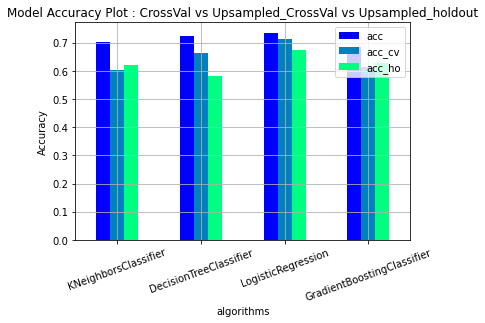

In [466]:
plot_df_bar(result[['acc','acc_cv', 'acc_ho']], xlabel='algorithms',
            title= 'Model Accuracy Plot : CrossVal vs Upsampled_CrossVal vs Upsampled_holdout')

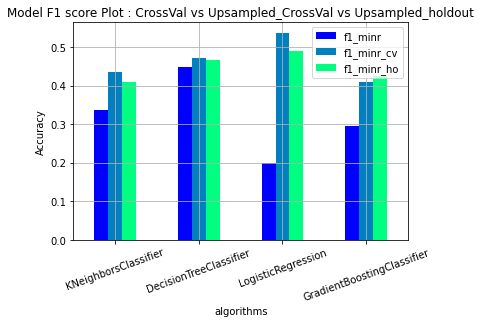

In [468]:
plot_df_bar(result[['f1_minr','f1_minr_cv', 'f1_minr_ho']], xlabel='algorithms',
            title= 'Model F1 score Plot : CrossVal vs Upsampled_CrossVal vs Upsampled_holdout')

### INFERENCE

#### **Strategy of using cross-validaion with ADASYN upsampling did work for Minority class "L5"**
******
**As noticed, accuracy for ---> NON-SAMPLED cross validation $\gt $ UPSAMPLED cross validation $\gt $ UPSAMPLED holdout**
******
**Whereas, F1 score for --->  UPSAMPLED cross validation $\gt $NON-SAMPLED cross validation $\gt $ UPSAMPLED holdout**
******
* This confirms the fact that accuracy of NON-sampled data is higher due to overfitting; hence its F1 score is poor
* **Upsampling with cross validation gives best interpretation of our models as:**
    * Minority class is synthetically balanced for fair estimation
    * **Since this is healthcare data realted to LIFE expectancy, FALSE NEGATIVES CAN NOT BE TOLERATED. So, Recall --> in turn F1 score is a good measure.** F1 score is best in class for  cross validation with Upsampling

---

# Q2 Feature Selection

<span style="color:blue">  
    
* Two datasets : heart-train.csv and heart-test.csv are used.
    
* Objective: to assess the impact of feature selection on training and test datasets.
    
* Procedure: 
    * identify a good feature subset using the training dataset and test this subset on the test data. 
    * Detailed explaination about discrepancies between train and test performance along with maximising performance.
</span>
<br>
<br>

## Data Set Information
<br>
The dataset contains cases of patients with heart condition. Dat aset is similar to [Cleveland database for heart diseas](https://archive.ics.uci.edu/ml/datasets/heart+disease).

* For convenience, datasets are predevided into heart-train.csv and heart-test.csv

In [209]:
## read train and test data into pandas dataframes
df_train = pd.read_csv('heart-train.csv')
df_test = pd.read_csv('heart-test.csv')
print("shape of training data: {} testing data: {}".format(df_train.shape,df_test.shape))

shape of training data: (199, 13) testing data: (100, 13)


In [210]:
print("training data sample")
df_train.head(3)

training data sample


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,60.0,0,253,0,35,0,279000.00,1.70,140,1,0,250,0
1,40.0,1,129,0,35,0,255000.00,0.90,137,1,0,209,0
2,86.0,0,582,0,38,0,263358.03,1.83,134,0,0,95,1


### Renaming attributes
* **Attribute names are lengthy and inefficent for handling in a notebook. Follwing function renames attribute names in place**

In [211]:
def rename_df_col(df, dict_col_rename = {'age':'age','anaemia':'anaemia','creatinine_phosphokinase':'cr_ph',
                                       'diabetes':'diabetes','ejection_fraction':'eject_fr',
                                       'high_blood_pressure':'high_bp','platelets':'platelets',
                                       'serum_creatinine':'serum_cr','serum_sodium':'serum_sod',
                                       'sex':'sex','smoking':'smoke','time':'time','DEATH_EVENT':'death'}):
    df.rename(columns=dict_col_rename, inplace=True)

In [212]:
rename_df_col(df_train)
rename_df_col(df_test)

### Attribute Information
* **Numerical attributes**
| age                  | cr_ph | eject_frac | platelets | serum_cr | serum_sod | time|
|:------------------------- |:------------------ |:---------------- |:---------- |:---------- | :---------- | :---------- | 


* **Categorical attributes**
| anaemia                  | diabetes | high_bp | sex | smoke |
|:------------------------- |:------------------ |:---------- |:---------- |:---------- | 
    
**Class Information**
* death (class attribute)
    * 1 = the patient is diseased **['D']**
    * 0 = the patient survived **['S']**

In [213]:
# ## define categorical and numerical columns
# cat_col = ['anaemia','diabetes','high_bp','sex','smoke']
# num_col = ['age','cr_ph','eject_frac','platelets','serum_cr', 'serum_sod', 'time']

### Statistics of data

In [214]:
df_train.nunique()

age           42
anaemia        2
cr_ph        145
diabetes       2
eject_fr      15
high_bp        2
platelets    136
serum_cr      34
serum_sod     25
sex            2
smoke          2
time         120
death          2
dtype: int64

**ATTRIBUTES**
* **Age**:     Range of values ( 30-83 ) ; Distribution from observation of quartiles (evenly distributed) 
* **Year**:    Range of values ( 58-69 ) ; Distribution from observation of quartiles (evenly distributed)
* **NNodes**:  Range of values ( 0-52 ) ; Distribution from observation of quartiles (Highly skewed to right; 75% data lies within ~2% of range)

**TARGET**
* **death**:   Binary variable (0,1). When treated as a numeric, we obtain mean < 0.5 : **So, label '0' is likely to be Majority class**

In [215]:
df_train.describe()

,age,anaemia,cr_ph,diabetes,eject_fr,high_bp,platelets,serum_cr,serum_sod,sex,smoke,time,death
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,60.822447,0.417085,634.834171,0.442211,39.050251,0.336683,263207.339698,1.403518,136.693467,0.643216,0.306533,128.216080,0.321608
std,12.234419,0.494321,1095.704449,0.497902,12.255178,0.473767,97202.912278,0.972159,4.583844,0.480258,0.462216,78.314302,0.468272
min,40.000000,0.000000,30.000000,0.000000,15.000000,0.000000,25100.000000,0.600000,113.000000,0.000000,0.000000,4.000000,0.000000
25%,50.000000,0.000000,121.500000,0.000000,30.000000,0.000000,216500.000000,0.950000,134.000000,0.000000,0.000000,73.000000,0.000000
50%,60.000000,0.000000,292.000000,0.000000,38.000000,0.000000,263000.000000,1.100000,137.000000,1.000000,0.000000,109.000000,0.000000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,302500.000000,1.500000,140.000000,1.000000,1.000000,196.500000,1.000000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.000000,148.000000,1.000000,1.000000,285.000000,1.000000


### Saggregate Input and Target features  

In [216]:
# seperate training dataframe into X_train and target to y_train.
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]

# seperate testing dataframe into  X_test and target to y_test.
X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]

In [217]:
X_train.head(3)

,age,anaemia,cr_ph,diabetes,eject_fr,high_bp,platelets,serum_cr,serum_sod,sex,smoke,time
0,60.0,0,253,0,35,0,279000.00,1.70,140,1,0,250
1,40.0,1,129,0,35,0,255000.00,0.90,137,1,0,209
2,86.0,0,582,0,38,0,263358.03,1.83,134,0,0,95


### Check for class imbalance
* We observe that, **data is imbalanced**
* But, imbalance is nearly equal ($ \approx $ 0.32% of minority class) in training and testing data

In [218]:
print("Ratio of Minority class '1' in training data: %0.3f" % (Counter(y_train)[1]/len(y_train)))
print("Ratio of Minority class '1' in testing data: %0.3f" % (Counter(y_test)[1]/len(y_test)))

Ratio of Minority class '1' in training data: 0.322
Ratio of Minority class '1' in testing data: 0.320


<br>
<br>

## Baseline model : No feature selection

### Gradient Boosting algorithm

Gradient Boosting works on principal of "Ensemble of Decision Tree". **Gradient Boosting Classifier implementeation in scikit-learn supports both binary and multi-class classification.**
* GB builds an additive model of weak decision trees in a forward stage-wise fashion
* The weak decison tree is successively Optimized using arbitrary differentiable loss functions.
* In each stage, n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. **But, addressed classification problem is Binary, hence it has induced only a single regression tree**

we can convert GB algorithm to stocastic GB using **'subsample'** parameter "f". it is fraction of samples choosen randomly in each iteration and used for fitting the individual base learners. 
* Smaller values of f introduce randomness into the algorithm and help prevent overfitting, acting as a kind of regularization. 
* Ideal range found by Friedman, who designed Gradient boosting is $ 0.5 \leq f \leq 0.8$ [link](https://en.wikipedia.org/wiki/Gradient_boosting#Stochastic_gradient_boosting)
* But, it leads to a reduction of variance and an increase in bias for smaller sample sizes; hence avoided in following implementation.

#### Define dataframe to hold results

In [219]:
df_result = pd.DataFrame(columns = ['Test','Train'], index=['baseline', 'sbfs', 'rfecv'])

#### Gradient Boosting Classifier

In [220]:
""" 
#Gradient Boosting Classifier(gb_clf) is trained with :
# loss function = deviance loss function to be optimized. ‘deviance’ refers to logistic regression for classification
which is suitable for this problem.
# random_state=0 maintained for reproducibility of results across other gb_clf models defined in notebook
"""
gb_clf_base = GradientBoostingClassifier(loss = 'deviance', random_state=seed)

#### Hold out accuracy with test data

In [221]:
# Us hold out technique
# gb_clf_base model is fit with train data 
gb_clf_base.fit(X_train,y_train)

#Test gb classifier test data and store value in y_pred
y_pred = gb_clf_base.predict(X_test)

#find hold out accuracy by comparing correct y_pred against actual y_test
acc_holdout = accuracy_score(y_test,y_pred)

#### Cross validation accuracy with train data

In [222]:
# Use Cross Validation to evaluate model gb_clf_base using train data : which is larger sample
scores = cross_val_score(gb_clf_base, X_train, y_train, cv=cv_folds)

#find average accuracy by taking numeric mean of all cross validation scores.
acc_cross_val = scores.mean()

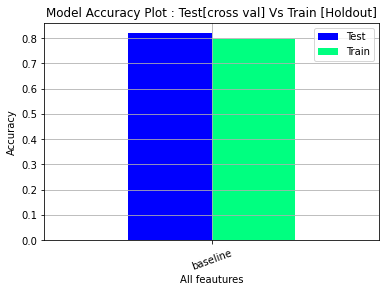

In [223]:
#Bar chart for hold-out and cross validation accuracies
df_result.loc['baseline'] = [acc_holdout, acc_cross_val]
plot_df_bar(df_result, title= 'Model Accuracy Plot : Test[cross val] Vs Train [Holdout]')


## Feature Selection

In Feature selection we need to find the best subset of all available features, which contains the smallest number of features which contribute most to the accuracy. Discard the remaining, unimportant features.

**Feature Selection Strategies**
* **Filter**: During Pre-processing step, filters evaluates the importance of features based only on their inherent characteristics, without incorporating any learning algorithm which is applied subsequently.
    * Evaluation is based on multiple statistical parameters like Gini Index, Chi-square index etc. 
    * They are extensively used on high dimensional data where wrapper methods have a prohibitive computational cost.
    * Unlike wrapper methods they are not subject to overfitting. 
* **Embedded methods**: This approach consists in algorithms which simultaneously perform model fitting andfeature selection. This is typically implemented by using a sparsity regularizer orconstraint which makes the weight of some features become zero. eg. Sparse Multinomial Logistic Regression, Automatic Relevance Determination Regression, LASSO, Ridge regression.
* **Wrapper**
    * **Sequential feature selection**: The classifier is “wrapped” in the feature selection mechanism. Feature subsets are evaluated directly based on their performance when used with that specific classifier. A key aspect of wrappers is the search strategy which generates the candidate feature subsets for evaluation.
        * **Sequential Forward Selection (SFS)**: This method starts with empty feature subset. In each step, algorithm adds  most informative feature to subset. This procedure repeats till model performance does not improve any further.
        * **Sequential Backward Eilimination (SBE)**: This method starts with whole feature space as subset. In each step, algorithm removes least informative feature. This procedure repeats till model performance does not improve any further. Hence, this is *feature selection by EXCLUSION*.  
        * **Floating Selection (FS))**: Floating selection is variant used with both above methods.
            * In case of SFS; once new additive feature included into subset; subset is reanalysed to find if *Exclusion of any present feature improves model performance*. If so, that feature is removed. 
            * In case of SBE; once another feature is excluded from subset; set of previousely excluded eatures is reanalysed to find if *Inclusion of any previousely eliminated feature improves model performance*. If so, that feature is added. 
    * **Recurssive feature eliminator with cross validation** [[Ref](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV)]: scikit-learn implements RFECV : Feature ranking with recursive feature elimination and cross-validated selection of the best number of features. This is also a greedy - aproach algorithm which works on similar algorithm like *Sequential Backward Eilimination (SBE)*.     

### Choice of Feature selection method:
#### Filter method : Not choosen 
Filters tend to be faster and less computationally expensive than wrapper methods. But it has following limitations:
* **Model dependancy is ignored** : Some models better aproximate certein data. But, filter ignores this model bias.
* **Training Data size dependancy** : Training data set in question is small; hence it would not be enough to model the statistical correlation between features. And Filter methods may provide worse results than wrapper methods. 
* **Feature Correlation are ignored** Sometimes, soe of top-k features can be strongly correalted. So, unnecessarily, excess features are selected without adding significant information gain. It may also happen that a lower importance feature boosts performance in presence of some other feature in sample space.

#### Recurssive feature eliminator with cross validation : Choosen for experiment
* Implement similar algorithm alike backward selection; BUT **AUTOMATES ADDITIONAL STEP TO LOCATE AND RETRAIN INNER MODEL WITH OPTIMAL k-features**

#### Sequential Backward FLOATING Eilimination selection: Choosen for experiement
* It adds a recosideration stage to INCLUDE PREVIOUSELY REMOVED samples which may improve performance with PRESENT SAMPLE-SPACE. THIS METHOD INADVENTLY CONSIDERS POSTERIORI "Support" of features for each other. This is neglected in FILTER TYPES OF SELECTIONS.

## Recurssive feature eliminator with cross validation 

* Recursive feature elimination with cross validation (RFECV) selects features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.


In [224]:
## Define instance of gradient boost classifier
gb_clf_RFECV = GradientBoostingClassifier(loss = 'deviance', random_state=seed)

In [225]:
%%time
## Implement Sequential Backward Floating Selection algorithm
##   min_features_to_select : Specify minimum N(features) to select
##   step : features to eliminate in each step
##   scoring : Performance evaluation criteria uesd is accuracy
##   cv : N(stratified cross-validation folds) stratification is important as data is imbalanced
##   n_jobs : Set to -1 to utilize all our available CPU cores for cross-validation.

k_sel = 2

rfecv = RFECV(estimator=gb_clf_RFECV,
              step=1,
              min_features_to_select=k_sel,
              n_jobs=-1,
              cv=StratifiedKFold(cv_folds),
              scoring='accuracy');

rfecv.fit(X_train, y_train);

Wall time: 2.89 s


RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=GradientBoostingClassifier(random_state=0),
      min_features_to_select=2, n_jobs=-1, scoring='accuracy')

Optimal number of features : 8


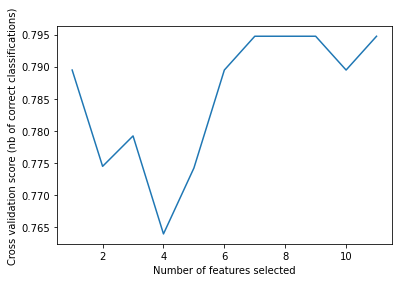

In [226]:
print("Optimal number of features : %d" % rfecv.n_features_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [227]:
print("Rank for each feature's index", rfecv.ranking_)
print("Mask for selecting top_k features", rfecv.support_)

Rank for each feature's index [1 3 1 4 1 2 1 1 1 1 5 1]
Mask for selecting top_k features [ True False  True False  True False  True  True  True  True False  True]


#### Performance with test data

* **predict()** function in RFECV automatically transforms test input to selected n_features **[Ref](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV.predict)**
    * Alternatively, we can manually mask test input using model attribute *support_*
* Testing accuracy is improved, but cross validation training accuracy is not changed significantly

In [228]:
## Cross validation accuracy for training data with selected features
acc_cross_val_rfecv = rfecv.grid_scores_[rfecv.n_features_ - k_sel]

# Hold-out accuracy.
#Predicting the y_pred_rfecv with selected feature test set.
y_pred_rfecv = rfecv.predict(X_test)

acc_holdout_rfecv = accuracy_score(y_pred_rfecv, y_test)

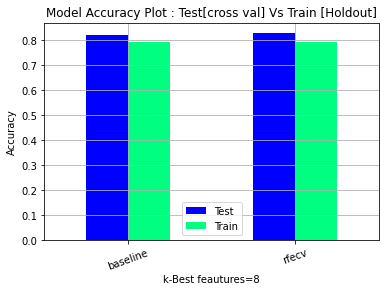

In [229]:
#Bar chart for hold-out and cross validation accuracies
df_result.loc['rfecv'] = [acc_holdout_rfecv,acc_cross_val_rfecv]

plot_df_bar(df_result, xlabel='k-Best feautures='+ str(rfecv.n_features_),
            title= 'Model Accuracy Plot : Test[cross val] Vs Train [Holdout]')

## Sequential feature selection 

Sequential feature selection algorithms are a family of greedy search algorithms that are used to reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k < d. It obtains following objectives [[Ref](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/)]:
* Improve the computational efficiency
* Reduce the generalization error of the model by removing irrelevant features[ or noise]

### Wrapper implementation for Sequential Backward Floating Eilimination (SBFE) 
* This algorithm in mlextend library is used for feature selection [[Ref](https://towardsdatascience.com/overview-of-feature-selection-methods-a2d115c7a8f7)].
* Wrapper compare all possible feature combinations and pick the set of feature combinations that produces the best outcome for a given machine learning algorithm. 
 1. Backward Feature Elimination: In the first phase, the classifier's performance is evaluated in accordance with each feature. Of all the features, the feature that performs the worst is eliminated.
 2. Floating inclusion: All previously removed features are reconsidered and a feature which improves model performance when included back in feature subset is included.
 3. 1 and 2 loop untill specified number of features defined apriori are included in samplespace.


In [230]:
## Define instance of fradient boost classifier
gb_clf_SBFS = GradientBoostingClassifier(loss = 'deviance', random_state=seed)

In [231]:
## Implement Sequential Backward Floating Selection algorithm
##   k_features : Specifys the N(features) to select
##   forward : Set to False, to performs step backward.
##   floating= Set to True, to perform floating inclusion 
##   verbose : logs the progress of the feature selector.
##   scoring : Performance evaluation criteria uesd is accuracy
##   cv : N(cross-validation folds)
##   n_jobs : Set to -1 to utilize all our available CPU cores for cross-validation.

sbfs = SFS(gb_clf_SBFS, 
           k_features=1, 
           forward=False, 
           floating=True, 
           scoring='accuracy',
           cv=cv_folds,
           n_jobs=-1)
sbfs = sbfs.fit(X_train, y_train, custom_feature_names=X_train.columns)

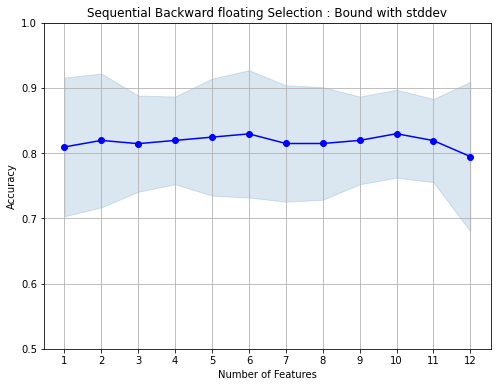

In [232]:
#Plot sequential backward floating feature selection to find the highest accuracy feature.
# attribute get_metric_dict() Returns a dictionary of feature_idx, cv_scores, avg_score, ci_bound, std_dev, std_err.

fig1 = plot_sfs(sbfs.get_metric_dict(), 
                ylabel='Accuracy',
                kind='std_dev', figsize=(8,6))

plt.ylim([0.5, 1])
plt.title('Sequential Backward floating Selection : Bound with stddev')
plt.grid()
plt.show()

### Locate  indexes for k features
* We can roughly see that at samplespace size 10, maximum accuracy is obtained
* Features contributing to this model setting are located using code below

In [233]:
## Define instance of fradient boost classifier
gb_clf_SBFS = GradientBoostingClassifier(loss = 'deviance', random_state=seed)

In [234]:
%%time
## attribute get_metric_dict() Returns a dictionary of feature_idx, cv_scores, avg_score, ci_bound, std_dev, std_err.
df_res = pd.DataFrame(pd.DataFrame(sbfs.get_metric_dict()).loc['avg_score'].astype('float64'))
## locate index of id where maximum average accuracy is obtained
k_features = df_res.idxmax()
k_num = int(k_features[0])

## Locate highest 'k' features:

#k_features = k_num and retrain sequential backward flaoting selector.
sbfs = SFS(gb_clf_SBFS, 
           k_features=k_num, 
           forward=False, 
           floating=True, 
           scoring='accuracy',
           cv=cv_folds,
           n_jobs=-1)
sbfs = sbfs.fit(X_train, y_train, custom_feature_names=X_train.columns)

Wall time: 3.03 s


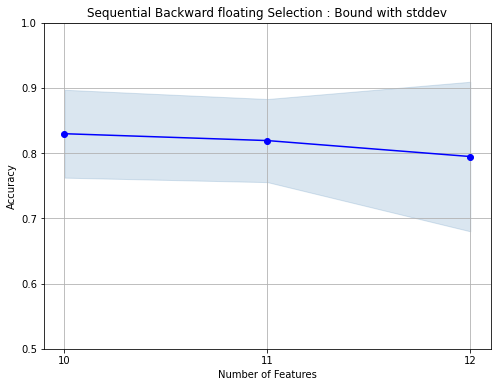

('age', 'anaemia', 'diabetes', 'eject_fr', 'platelets', 'serum_cr', 'serum_sod', 'sex', 'smoke', 'time')


In [235]:
#Plot sequential backward floating feature selection to find the highest accuracy feature.
# attribute get_metric_dict() Returns a dictionary of feature_idx, cv_scores, avg_score, ci_bound, std_dev, std_err.

fig1 = plot_sfs(sbfs.get_metric_dict(), 
                ylabel='Accuracy',
                kind='std_dev', figsize=(8,6))

plt.ylim([0.5, 1])
plt.title('Sequential Backward floating Selection : Bound with stddev')
plt.grid()
plt.show()
print(sbfs.k_feature_names_)


### Retrain classifier with feature subset

In [238]:
# CV accuracy is already found in previous stage
acc_cross_val_sbfs =  sbfs.k_score_

#select k best features from train and test set for training the classifier. 
X_train_sbfs = X_train[list(sbfs.k_feature_names_)]
X_test_sbfs = X_test[list(sbfs.k_feature_names_)]

#Fitting gbc classifier on X & y Features.
gb_clf_SBFS.fit(X_train_sbfs,y_train)

#Predicting the y_pred_sbfs with selected feature test set.
y_pred_sbfs = gb_clf_SBFS.predict(X_test_sbfs)


# Hold-out accuracy.
acc_holdout_sbfs = accuracy_score(y_pred_sbfs,y_test)

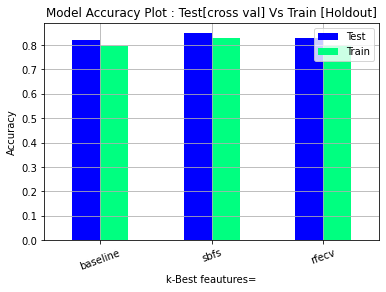

In [239]:
#Bar chart for hold-out and cross validation accuracies
df_result.loc['sbfs'] = [acc_holdout_sbfs,acc_cross_val_sbfs]

plot_df_bar(df_result, xlabel='k-Best feautures=',
            title= 'Model Accuracy Plot : Test[cross val] Vs Train [Holdout]')

# Inference

**FEATURE SELECTION METHOD**
* Based on the resultant graph,  resultant accuracies for training data using cross validation are consistent across all feature sets
* Accuracy of the classifier is most improved with Wrapper-based methods. 

**The discrepancies between performance on the training and test data** is due to two facts:
1. Training data is hardly twice the size of testing data. *This is reason behind smaller training accuracy compared to testing accuracy*
2. Sample size for both reaining and testing data is also relatively small [$ \lt 200$]

*******
* Comparing wall times; Recursive feature selection(RFECV) is faster than Backward floating elimination (SBFS)
* **Wrapper based Sequential Forward Selection feature selection method is faster than backward elimination**. Due to option for early stopping, it can also be memory efficient.
* But, accuracy for Backward Elimination is high as it starts with large entire sample space removes less important features. As Given dataset is not huge, backward elimination would work.
* *Hence, For given dataset, Sequential Forward floating Selection is model of choice based on accuracy metric*
*******